## Project: Urinary biomarkers for pancreatic cancer

The original dataset is available from https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer

Pancreatic cancer is an extremely deadly type of cancer. Once diagnosed, the five-year survival rate is less than 10%. However, if pancreatic cancer is caught early, the odds of surviving are much better. Unfortunately, many cases of pancreatic cancer show no symptoms until the cancer has spread throughout the body. A diagnostic test to identify people with pancreatic cancer could be enormously helpful.

The goal is utlizing this dataset to predict diagnosis, and more specifically, to differentiate between 3 (pancreatic cancer) versus 2 (non-cancerous pancreas condition) and 1 (healthy). 

### In this notebook, we will focus on Modeling.

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# Import testing and training datasets generated previously
X_train =  pd.read_csv("./archive/X_train.csv", index_col=0)
y_train =  pd.read_csv("./archive/y_train.csv", index_col=0)
X_test =  pd.read_csv("./archive/X_test.csv", index_col=0)
y_test =  pd.read_csv("./archive/y_test.csv", index_col=0)

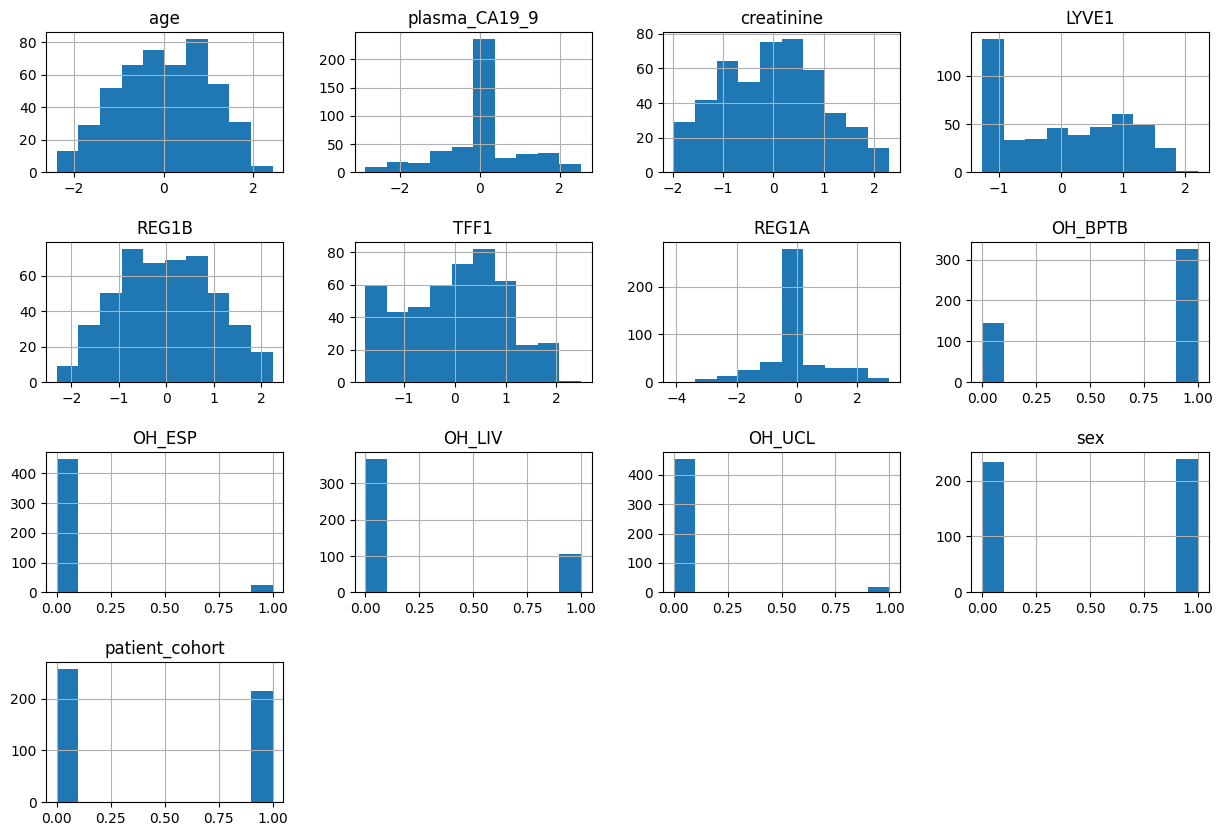

In [3]:
# Look into distributions of feature values
X_train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

## Select appropriate machine learning models

This is a multi-class classificaiton problem because our goal is to distinguish 3 (pancreatic cancer) versus 2 (non-cancerous pancreas condition) and 1 (healthy). In our previous EDA, we learned that there is a relatively strong correlation between some of our features. Thus, we will choose the following machine learning algorithms for further analysis, but not Naive Bayes, which can not learn interactions between features.
***
* Logistic Regression (logreg)
* K-nearest Neighbors (KNN)
* Decision Tree Classifier (dtc)
* Random Forest Classifier (rfc)
* Gradient Boosting Classifier (gbc)
* Support Vector Machine (svc)
***
We will first do a quick comparison for all the six classification models with default settings and see which one performs the best out of the box.



## Visualize classification model performance

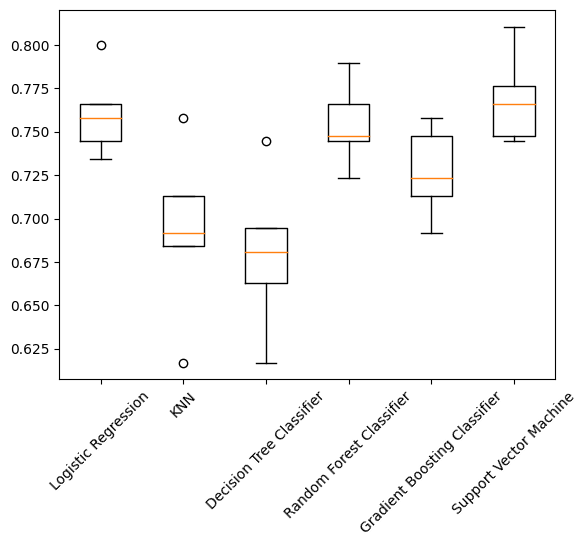

In [4]:
# Create models dictionary
models = {
    "Logistic Regression": LogisticRegression(random_state=22), 
    "KNN": KNeighborsClassifier(), 
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=22),
    "Random Forest Classifier": RandomForestClassifier(random_state=22),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=22),
    "Support Vector Machine": SVC(random_state=22)
}
results = []

# Loop through the models' values
for model in models.values():
  
  # Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
  kf = KFold(n_splits=5, random_state=22, shuffle=True)
  
  # Perform cross-validation
  cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf)
  results.append(cv_results)
plt.boxplot(results, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

We can see that three of the models, logreg, rfc, and svc, have the average of accuracy around 75%, while KNN and dtc have a significantly lower score compared with the other competitors. Keep in mind that this is just a quick comparison without any optimization. In the next step, we will further fine tune each model and see if the final result is alinged with our initial evaluation after hyperparameter tuning.

## Hyperparameter tuning for each classification model

Depending on the run time, we implement either the grid search or random search methods for identifying the best hyperparameter value.

In [5]:
# Logistic Regression
# Create the parameter space
params = {"penalty": ["l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": [0.001, 0.01, 0.1, 1.0, 10, 100],
         "max_iter": [1000]}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the GridSearchCV object
logreg_cv = GridSearchCV(LogisticRegression(random_state=22), params, cv=kf)

start_time = time.time()

# Fit the data to the model
logreg_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("GridSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: %.3f" % (logreg_cv.best_score_))

GridSearchCV Run Time: 8.794
Tuned Logistic Regression Parameters: {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.14294285714285712}
Tuned Logistic Regression Best Accuracy Score: 0.763


In [6]:
# KNN
# Create the parameter space
params = {'n_neighbors':np.arange(1,50),
          'p': [1, 2],
          'weights': ['uniform', 'distance'], 
          'leaf_size': np.arange(10,50)}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the RandomizedSearchCV object
knn_cv = RandomizedSearchCV(KNeighborsClassifier(), params, cv=kf, random_state=22)

start_time = time.time()

# Fit the data to the model
knn_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("RandomizedSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(knn_cv.best_params_))
print("Tuned KNN Best Accuracy Score: %.3f" % (knn_cv.best_score_))

RandomizedSearchCV Run Time: 0.359
Tuned KNN Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 48, 'leaf_size': 24}
Tuned KNN Best Accuracy Score: 0.714


In [7]:
# Decision Tree Classifier
# Create the parameter space
params = {'criterion': ['entropy', 'gini'],
          'max_depth': np.arange(1,50)}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the GridSearchCV object
dtc_cv = GridSearchCV(DecisionTreeClassifier(random_state=22), params, cv=kf)

start_time = time.time()

# Fit the data to the model
dtc_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("GridSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(dtc_cv.best_params_))
print("Tuned Decision Tree Best Accuracy Score: %.3f" % (dtc_cv.best_score_))

GridSearchCV Run Time: 2.043
Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 8}
Tuned Decision Tree Best Accuracy Score: 0.731


In [8]:
# Random Forest Classifier
# Create the parameter space
params = {'criterion': ['entropy', 'gini'],
          'n_estimators': np.linspace(start = 100, stop = 2000, num = 20, dtype=int),
          'max_depth': np.linspace(5, 30, 6, dtype=int)}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the RandomizedSearchCV object
rfc_cv = RandomizedSearchCV(RandomForestClassifier(random_state=22, n_jobs=-1), params, cv=kf, random_state=22)

start_time = time.time()

# Fit the data to the model
rfc_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("RandomizedSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(rfc_cv.best_params_))
print("Tuned Random Forest Best Accuracy Score: %.3f" % (rfc_cv.best_score_))

RandomizedSearchCV Run Time: 33.885
Tuned Random Forest Parameters: {'n_estimators': 1300, 'max_depth': 10, 'criterion': 'entropy'}
Tuned Random Forest Best Accuracy Score: 0.767


In [9]:
# Gradient Boosting Classifier
# Create the parameter space
params = {'n_estimators': np.linspace(start = 100, stop = 2000, num = 20, dtype=int),
          'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
          'max_depth': [3, 4, 5, 6, 7, 8]}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the RandomizedSearchCV object
gbc_cv = RandomizedSearchCV(GradientBoostingClassifier(random_state=22), params, cv=kf, random_state=22)

start_time = time.time()

# Fit the data to the model
gbc_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("RandomizedSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Gradient Boosting Parameters: {}".format(gbc_cv.best_params_))
print("Tuned Gradient Boosting Best Accuracy Score: %.3f" % (gbc_cv.best_score_))

RandomizedSearchCV Run Time: 154.016
Tuned Gradient Boosting Parameters: {'n_estimators': 1800, 'max_depth': 8, 'learning_rate': 0.25}
Tuned Gradient Boosting Best Accuracy Score: 0.737


In [10]:
# Support Vector Machine
# Create the parameter space
params = {"C": [0.001, 0.01, 0.1, 1.0, 10, 100],
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':[2, 3, 4, 5, 6],
          'gamma': [0.01, 0.1, 1.0, 10],
          'coef0': [0.1, 1.0, 10]}

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the RandomizedSearchCV object
svc_cv = RandomizedSearchCV(SVC(random_state=22), params, cv=kf, random_state=22)

start_time = time.time()

# Fit the data to the model
svc_cv.fit(X_train, y_train.values.ravel())

elapsed_time = time.time() - start_time
print("RandomizedSearchCV Run Time: %.3f" % (elapsed_time))

# Print the tuned parameters and score
print("Tuned Support Vector Machine Parameters: {}".format(svc_cv.best_params_))
print("Tuned Support Vector Machine Best Accuracy Score: %.3f" % (svc_cv.best_score_))

RandomizedSearchCV Run Time: 0.572
Tuned Support Vector Machine Parameters: {'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'coef0': 10, 'C': 1.0}
Tuned Support Vector Machine Best Accuracy Score: 0.761


After hyperparameter tuning, three are only three models, logreg, rfc, and svc, with an accuracy score larger than 76%. This final result is consistent with our aforementioned observation. 

We will further look into these three top candidates and compare their performance. Since this is a multi-class classification task, we will specifically examine the following evaluation metrics: ***average accuracy, f1-score, and log-loss.*** We will also assess confusion matrix and see if these performance metrics can further guide us on model selection. 

## Identify the best classification model using relevant performance metrics

Keep in mind that this is a multi-class but not a binary classification problem and there is yet no well-developed ROC-AUC score for multi-class. Additionally, our dataset is quite balanced so the difference between macro- and weighted- average will be presumably small.

In addition to the three commonly used metrics, plotting confusion matrices is also a great way to review our model performance for a multi-class classification problem. 
Being able to identify misclassified observations in each class will allow us to determine if we need to build additional features to improve our overall model.

In [11]:
# Create Confusion Matrix Plots
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Logistic Regression: Accuracy=0.737
Logistic Regression: f1-score=0.733
Logistic Regression: log-loss=0.612
              precision    recall  f1-score   support

           1       0.70      0.78      0.74        36
           2       0.76      0.60      0.67        42
           3       0.76      0.85      0.80        40

    accuracy                           0.74       118
   macro avg       0.74      0.74      0.73       118
weighted avg       0.74      0.74      0.73       118

Confusion matrix, without normalization
[[28  4  4]
 [10 25  7]
 [ 2  4 34]]
Normalized confusion matrix
[[0.77777778 0.11111111 0.11111111]
 [0.23809524 0.5952381  0.16666667]
 [0.05       0.1        0.85      ]]


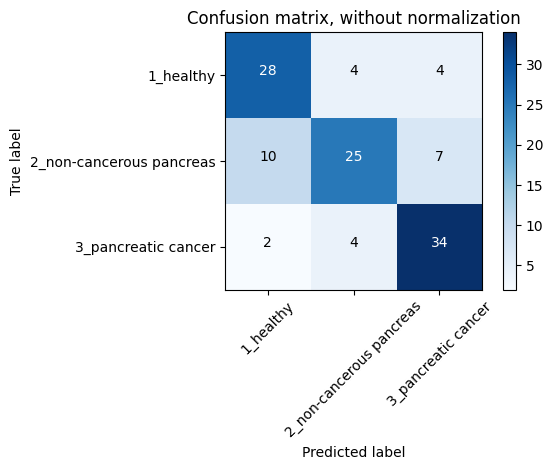

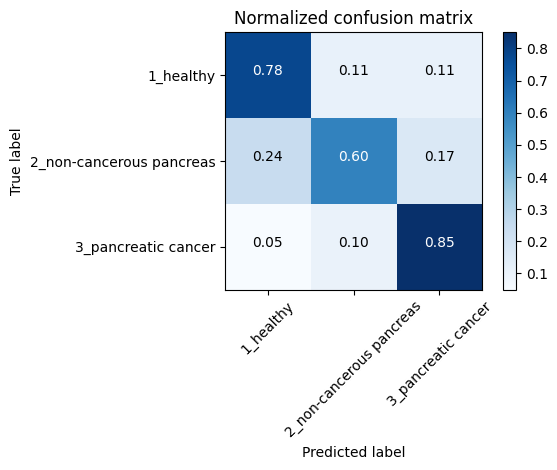

In [12]:
# Logistic Regression

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the Logistic Regression model
logreg = LogisticRegression(C = 1.0, 
                            max_iter = 1000, 
                            penalty = 'l2', 
                            tol = 0.14294285714285712, 
                            random_state=22)

# Fit the data to the model
logreg.fit(X_train, y_train.values.ravel())

# Predict using the model
y_pred_logreg = logreg.predict(X_test)

# Predict probabilities of each patient in the test set having a cancer diagnosis (which is in the 3rd column of the output of .predict_proba)
y_pred_prob_logreg = logreg.predict_proba(X_test)
cancer_prob_logreg = y_pred_prob_logreg[:,2]

ac_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average='weighted')
ll_logreg = log_loss(y_test, y_pred_prob_logreg)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cr_logreg = classification_report(y_test, y_pred_logreg)

print('Logistic Regression: Accuracy=%.3f' % (ac_logreg))
print('Logistic Regression: f1-score=%.3f' % (f1_logreg))
print('Logistic Regression: log-loss=%.3f' % (ll_logreg))
print(cr_logreg)

class_names=['1_healthy','2_non-cancerous pancreas','3_pancreatic cancer']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_logreg, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/logreg_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_logreg, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/logreg_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Random Forest: Accuracy=0.746
Random Forest: f1-score=0.744
Random Forest: log-loss=0.617
              precision    recall  f1-score   support

           1       0.70      0.72      0.71        36
           2       0.69      0.64      0.67        42
           3       0.83      0.88      0.85        40

    accuracy                           0.75       118
   macro avg       0.74      0.75      0.74       118
weighted avg       0.74      0.75      0.74       118

Confusion matrix, without normalization
[[26  9  1]
 [ 9 27  6]
 [ 2  3 35]]
Normalized confusion matrix
[[0.72222222 0.25       0.02777778]
 [0.21428571 0.64285714 0.14285714]
 [0.05       0.075      0.875     ]]


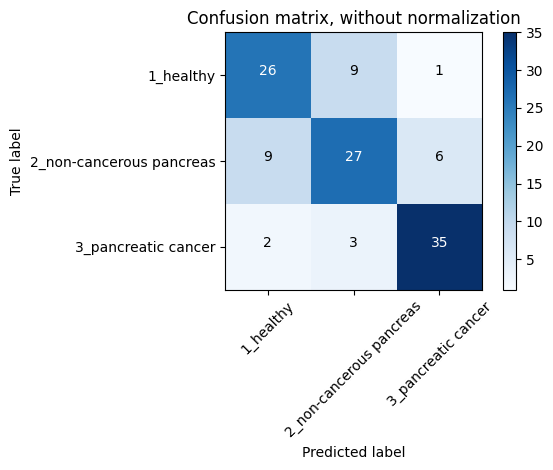

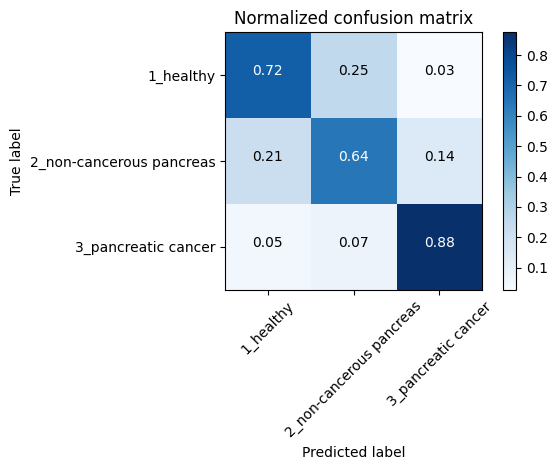

In [13]:
# Random Forest Classifier

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the Random Forest Classifier model
rfc = RandomForestClassifier(criterion = 'entropy',
                             n_estimators = 1300, 
                             max_depth = 10,
                             random_state=22)

# Fit the data to the model
rfc.fit(X_train, y_train.values.ravel())

# Predict using the model
y_pred_rfc = rfc.predict(X_test)

# Predict probabilities of each patient in the test set having a cancer diagnosis (which is in the 3rd column of the output of .predict_proba)
y_pred_prob_rfc = rfc.predict_proba(X_test)
cancer_prob_rfc = y_pred_prob_rfc[:,2]

ac_rfc = accuracy_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc, average='weighted')
ll_rfc = log_loss(y_test, y_pred_prob_rfc)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cr_rfc = classification_report(y_test, y_pred_rfc)

print('Random Forest: Accuracy=%.3f' % (ac_rfc))
print('Random Forest: f1-score=%.3f' % (f1_rfc))
print('Random Forest: log-loss=%.3f' % (ll_rfc))
print(cr_rfc)

class_names=['1_healthy','2_non-cancerous pancreas','3_pancreatic cancer']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_rfc, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/logreg_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_rfc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/logreg_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

Support Vector Machine: Accuracy=0.788
Support Vector Machine: f1-score=0.787
Support Vector Machine: log-loss=0.582
              precision    recall  f1-score   support

           1       0.77      0.83      0.80        36
           2       0.74      0.69      0.72        42
           3       0.85      0.85      0.85        40

    accuracy                           0.79       118
   macro avg       0.79      0.79      0.79       118
weighted avg       0.79      0.79      0.79       118

Confusion matrix, without normalization
[[30  6  0]
 [ 7 29  6]
 [ 2  4 34]]
Normalized confusion matrix
[[0.83333333 0.16666667 0.        ]
 [0.16666667 0.69047619 0.14285714]
 [0.05       0.1        0.85      ]]


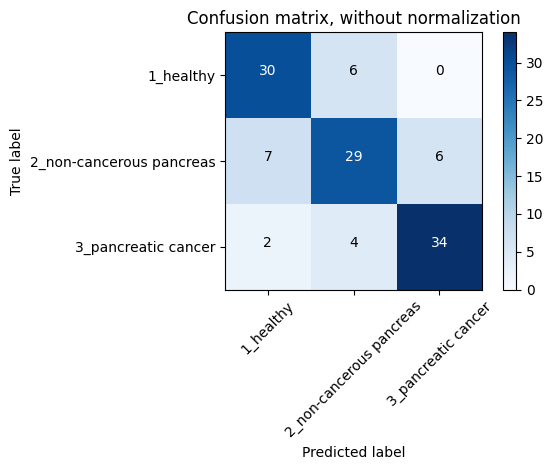

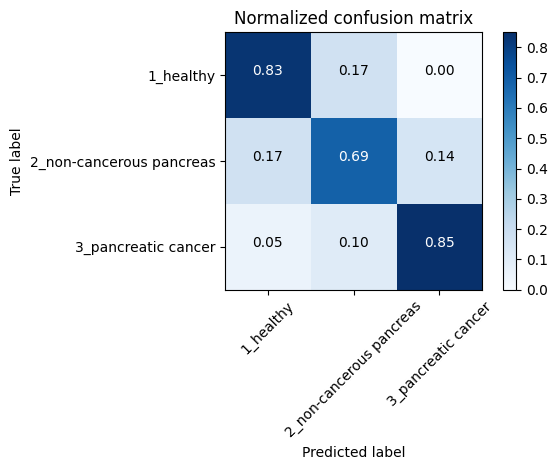

In [14]:
# Support Vector Machine

# Instantiate a KFold object to perform 5 splits, setting shuffle to True and random_state to 22.
kf = KFold(n_splits=5, random_state=22, shuffle=True)

# Instantiate the Support Vector Machine model
svc = SVC(probability = True,
          kernel = 'poly',
          C = 1.0, 
          degree = 2,
          gamma = 0.1,
          coef0 = 10,
          random_state=22)

# Fit the data to the model
svc.fit(X_train, y_train.values.ravel())

# Predict using the model
y_pred_svc = svc.predict(X_test)

# Predict probabilities of each patient in the test set having a cancer diagnosis (which is in the 3rd column of the output of .predict_proba)
y_pred_prob_svc = svc.predict_proba(X_test)
cancer_prob_svc = y_pred_prob_svc[:,2]

ac_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
ll_svc = log_loss(y_test, y_pred_prob_svc)
cm_svc = confusion_matrix(y_test, y_pred_svc)
cr_svc = classification_report(y_test, y_pred_svc)

print('Support Vector Machine: Accuracy=%.3f' % (ac_svc))
print('Support Vector Machine: f1-score=%.3f' % (f1_svc))
print('Support Vector Machine: log-loss=%.3f' % (ll_svc))
print(cr_svc)

class_names=['1_healthy','2_non-cancerous pancreas','3_pancreatic cancer']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_svc, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/logreg_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm_svc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/logreg_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

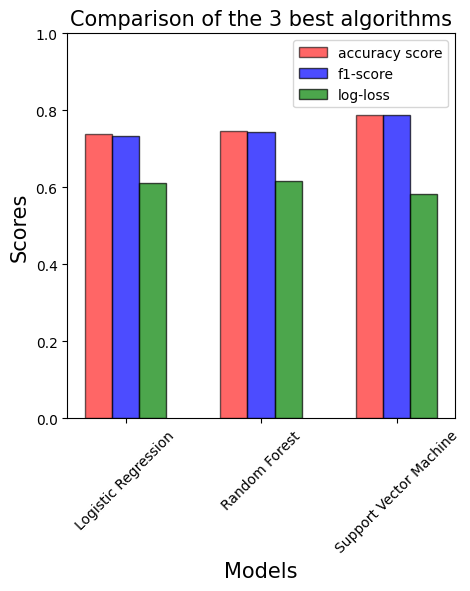

In [15]:
#Plot and compare accuracy score, f1-score, and log-loss

Models = [ 'Logistic Regression','Random Forest','Support Vector Machine']
ac = [ac_logreg, ac_rfc, ac_svc]
f1 = [f1_logreg, f1_rfc, f1_svc]
ll = [ll_logreg, ll_rfc, ll_svc]

index_ac=[0.8, 1.8, 2.8]
index_f1=[1,2,3]
index_ll=[1.2,2.2,3.2]
plt.figure(figsize=(5,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Scores',fontsize=15)
plt.title('Comparison of the 3 best algorithms',fontsize=15)
_=plt.bar(index_ac,ac,color='red',alpha=0.6,label='accuracy score',edgecolor='k',width=0.2)
_=plt.bar(index_f1,f1,color='blue',alpha=0.7,label='f1-score',edgecolor='k',width=0.2)
_=plt.bar(index_ll,ll,color='green',alpha=0.7,label='log-loss',edgecolor='k',width=0.2)
plt.xticks([1,2,3], Models, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.show()

We can clearly see that ***Support Vector Machine (svc) has the highest accuracy and f1-score with the lowest log-loss*** compared with the other two competitors. In this case, the final winner for this project is svc. Keep in mind that svc is memory-intensive, hard to interpret, and kind of annoying to run and tune.

The runner-up algorithm for this project is Random Forest Classifier (rfc) since it has a decent accuracy and f1-score. Notably, it has the highest recall score for the class of pacreatic cancer which could be useful if identifying cancer patients is the first priority. 

Although Logistic Regression (logreg) is not on the top of our favorites, it can take in new data using an online gradient descent method and easily be updated. Both svc and rfc do not support online learning, so we have to rebuild our models when new examples come in.

## Plot feature importances using Random Forest

In this final step, we will plot the top 10 feature importances to gain a perspective on which features are driving the model predictions. Random Forest is handful to investigate the importance of a set of features. We should always consider Random Forest when building a decision tree, especially for a multi-class classification task.

10


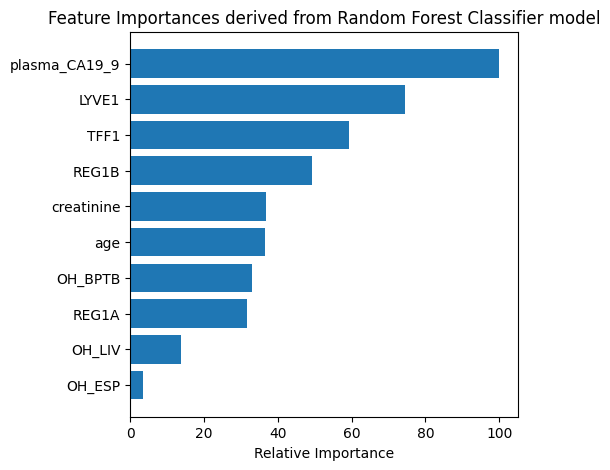

In [16]:
# Plot feature importances
feature_importance = rfc.feature_importances_

# Make importances relative to max importance
relative_importance = 100.0 * (feature_importance / feature_importance.max())[:10]
sorted_idx = np.argsort(relative_importance)[:10]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(5,5))
plt.barh(pos, relative_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importances derived from Random Forest Classifier model',fontsize=12)
plt.show()

One of the purposes of the original study is to access if REG1A can be replaced by REG1B in the panel and further improve the performance of model to detect pancreatic cancer. REG1B is indeed more important than REG1A in our bar plot of feature importance derived from Random Forest. As a result, we should prioritize REG1B over REG1A if we want to limit sample collections and reduce cost.